# Creation of a recurrent neural network (RNN) for the classification of reviews from the imdb data set.

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, SimpleRNN, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import pad_sequences
from keras.datasets import imdb

# from sklearn.metrics import classification_report

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
from datetime import datetime
from tabulate import tabulate

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
print("TensorFlow", tf.__version__)

TensorFlow 2.16.1


## Load data

In [2]:
max_features = 10000
maxlen = 500
metrics_file_name = 'models_metrics.json'

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)


X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
     

## Functions

In [3]:
def plot_model(history=None, model_version='v1'):
    # Convert '_' to ' ' in model version for plot title
    model_version = model_version.replace('_', ' ')
    
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['accuracy'],
             label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'],
             label='Validation Accuracy', color='green', marker='x')
    plt.plot(history.history['loss'],
             label='Training Loss', color='red', linestyle='--')
    plt.plot(history.history['val_loss'], label='Validation Loss',
             color='goldenrod', linestyle='--', marker='x')
    plt.title(
        f'Model {model_version} - Training and Validation Performance', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy and Loss (Scored Separately)', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


def save_metrics(loss, accuracy, work_time, file_name="model_metrics.json", comment=""):
  data = {"Created_at": datetime.now().isoformat(), "Loss": loss, "Accuracy": accuracy, "Time": work_time, "Comment": comment}
  try:
    with open(file_name, "r") as f:
      existing_data = json.load(f)
  except FileNotFoundError:
    existing_data = []
  with open(file_name, "w") as f:
    json.dump(existing_data + [data], f, indent=4)



def display_metrics(file_name="model_metrics.json"):
  try:
    with open(file_name, "r") as f:
      metrics_data = json.load(f)
  except FileNotFoundError:
    print("No metrics file found.")
    return

  if not all(key in entry for entry in metrics_data for key in ["Loss", "Accuracy", "Time", "Comment"]):
    print("Warning: Some entries in the metrics file might be missing required keys.")

  headers = ["Loss", "Accuracy", "Time", "Comment"]
  rows = [[entry.get("Loss"), entry.get("Accuracy"), entry.get("Time"), entry.get("Comment")] for entry in metrics_data]
  print(tabulate(rows, headers=headers, tablefmt="pretty"))

def get_metrics(file_name="model_metrics.json"):
  try:
    with open(file_name, "r") as f:
      metrics_data = json.load(f)
  except FileNotFoundError:
    print("No metrics file found.")
    return

  if not all(key in entry for entry in metrics_data for key in ["Loss", "Accuracy", "Time", "Comment"]):
    print("Warning: Some entries in the metrics file might be missing required keys.")

  # Convert the JSON data to a DataFrame
  df = pd.DataFrame(metrics_data)
  df.drop('Created_at', axis=1, inplace=True)
  df.replace('_', ' ', regex=True, inplace=True)
  return df





## Models

In [79]:
# define evaluated models list 
models_list = ['RNN', 'LSTM', 'Bidirectional_RNN', 'Bidirectional_LTSM', 'Deep_RNN', 'Deep_LTSM']
regularizer = l2(0.001)

# function for building of the selected model
def build_model(model_name):
    model_name = model_name
    model = Sequential(name=model_name)
    model.add(Embedding(max_features, 32, name='embed'))
    #
    if model_name == 'RNN':
        model.add(SimpleRNN(32, name='rnn', kernel_regularizer=regularizer))
        model.add(Dropout(0.4))
    if model_name == 'LSTM':
        model.add(LSTM(32, name='lstm'))
        model.add(Dropout(0.3))
    if model_name == 'Bidirectional_RNN':
        model.add(Bidirectional(SimpleRNN(32), dropout=0.2, return_sequences=True, name='bidirectional_rnn1'))
        model.add(Bidirectional(SimpleRNN(32), dropout=0.2, name='bidirectional_rnn2'))
        # model.add(Dropout(0.4))
    if model_name == 'Bidirectional_LTSM':
        model.add(Bidirectional(LSTM(32), name='bidirectional_lstm'))
        model.add(Dropout(0.3))
    if model_name == 'Deep_RNN':
        model.add(SimpleRNN(32, dropout=0.2, return_sequences=True, name='rnn1'))
        model.add(SimpleRNN(32, dropout=0.2, name='rnn2'))
        # model.add(Dropout(0.4))
    if model_name == 'Deep_LTSM':
        model.add(LSTM(32, dropout=0.3, return_sequences=True, name='lstm1')) # 32
        model.add(LSTM(32, dropout=0.2, name='lstm2')) #32
    model.add(Dense(1, activation='sigmoid', name='dense'))
    return model

In [61]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

def process_model(model_name):
    model = build_model(model_name)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # print(model.summary())

    start_time = datetime.now()
    print(f'\nTraining model: {model_name}')
    history = model.fit(X_train, y_train, epochs=25, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])
    end_time = datetime.now() 
    work_time = (end_time - start_time).total_seconds()
    work_time = round(work_time, 1)

    plot_model(history, model_version=model_name)

    # Evaluate the model
    print(f'\nEvaluating model: {model_name}')
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    save_metrics(loss=test_loss, accuracy=test_acc, work_time=work_time, file_name=metrics_file_name, comment=f'{model_name}')
    print(f'\nModel: {model_name}\n Test loss: {test_loss} Test accuracy: {test_acc} Time: {work_time}')
    #display_metrics(file_name=metrics_file_name)

    

## RNN model


Training model: RNN
Epoch 1/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.5538 - loss: 0.7012 - val_accuracy: 0.7985 - val_loss: 0.4766 - learning_rate: 0.0010
Epoch 2/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.7408 - loss: 0.5524 - val_accuracy: 0.8310 - val_loss: 0.4164 - learning_rate: 0.0010
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.8647 - loss: 0.3591 - val_accuracy: 0.8426 - val_loss: 0.3910 - learning_rate: 0.0010
Epoch 4/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9065 - loss: 0.2692 - val_accuracy: 0.8478 - val_loss: 0.4018 - learning_rate: 0.0010
Epoch 5/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.9444 - loss: 0.1853 - val_accuracy: 0.8495 - val_loss: 0.4244 - learning_rate: 0.0010
Epoch 6/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.9688 - loss: 0.1243 - val_accuracy: 0.8497 - val_loss: 0.4519 - learning_rate: 0.0010
Epoch 7/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step -

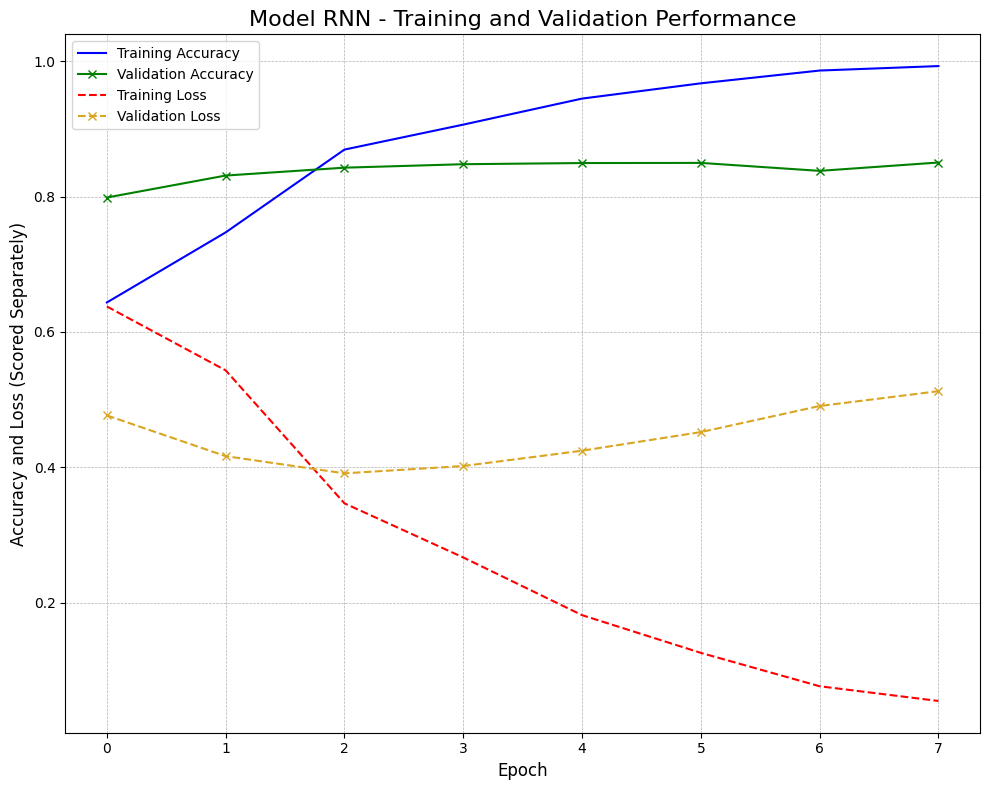


Evaluating model: RNN
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8419 - loss: 0.3935

Model: RNN
 Test loss: 0.3909606337547302 Test accuracy: 0.8426399827003479 Time: 107.5
CPU times: user 2min 11s, sys: 19.9 s, total: 2min 31s
Wall time: 1min 53s


In [17]:
%%time

process_model('RNN')

## LSTM model


Training model: LSTM
Epoch 1/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 36s 179ms/step - accuracy: 0.6359 - loss: 0.6288 - val_accuracy: 0.8294 - val_loss: 0.3981 - learning_rate: 0.0010
Epoch 2/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 35s 179ms/step - accuracy: 0.8644 - loss: 0.3386 - val_accuracy: 0.8505 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 35s 181ms/step - accuracy: 0.9159 - loss: 0.2307 - val_accuracy: 0.8696 - val_loss: 0.3106 - learning_rate: 0.0010
Epoch 4/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 35s 177ms/step - accuracy: 0.9413 - loss: 0.1705 - val_accuracy: 0.8689 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 5/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 35s 180ms/step - accuracy: 0.9499 - loss: 0.1463 - val_accuracy: 0.8669 - val_loss: 0.3383 - learning_rate: 0.0010
Epoch 6/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 35s 179ms/step - accuracy: 0.9646 - loss: 0.1127 - val_accuracy: 0.8605 - val_loss: 0.3721 - learning_rate: 0.0010
Epoch 7/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 35s 177m

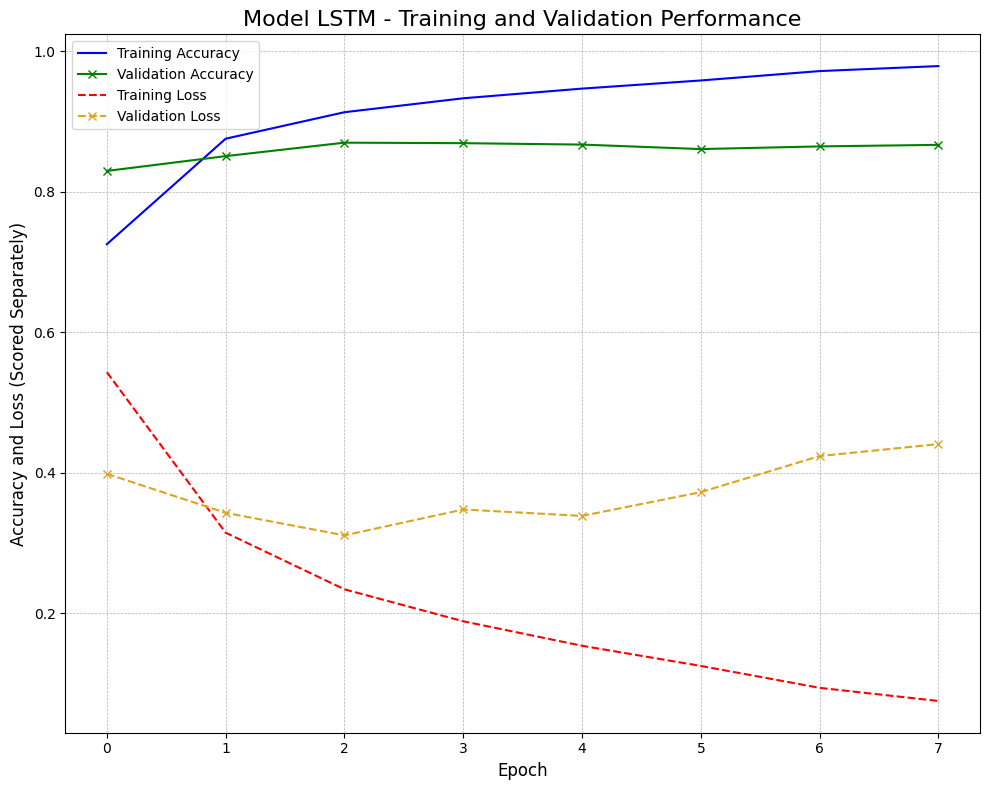


Evaluating model: LSTM
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8688 - loss: 0.3124

Model: LSTM
 Test loss: 0.3105675280094147 Test accuracy: 0.8696399927139282 Time: 281.8
CPU times: user 4min 42s, sys: 46.8 s, total: 5min 28s
Wall time: 4min 53s


In [18]:
%%time

process_model('LSTM')

## Bidirectional RNN Model


Training model: Bidirectional_RNN
Epoch 1/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.5531 - loss: 0.6767 - val_accuracy: 0.7426 - val_loss: 0.5379 - learning_rate: 0.0010
Epoch 2/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.8051 - loss: 0.4547 - val_accuracy: 0.8182 - val_loss: 0.4244 - learning_rate: 0.0010
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.8640 - loss: 0.3335 - val_accuracy: 0.8271 - val_loss: 0.4386 - learning_rate: 0.0010
Epoch 4/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.8980 - loss: 0.2676 - val_accuracy: 0.8406 - val_loss: 0.3770 - learning_rate: 0.0010
Epoch 5/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9325 - loss: 0.1946 - val_accuracy: 0.8487 - val_loss: 0.4110 - learning_rate: 0.0010
Epoch 6/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9495 - loss: 0.1487 - val_accuracy: 0.8483 - val_loss: 0.4230 - learning_rate: 0.0010
Epoch 7/25
196/196 ━━━━━━━━━━━━━━━━━

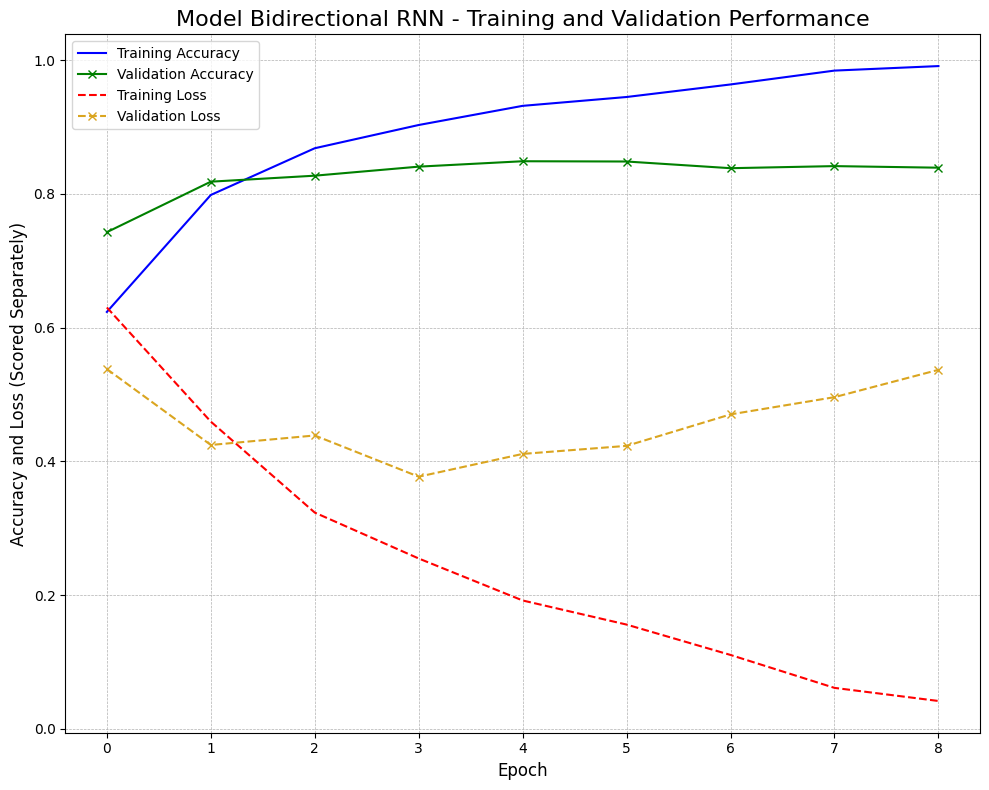


Evaluating model: Bidirectional_RNN
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8402 - loss: 0.3779

Model: Bidirectional_RNN
 Test loss: 0.376957505941391 Test accuracy: 0.8406400084495544 Time: 177.9
CPU times: user 4min 41s, sys: 38.1 s, total: 5min 19s
Wall time: 3min 9s


In [26]:
%%time

process_model('Bidirectional_RNN')

## Bidirectional LTSM Model


Training model: Bidirectional_LTSM
Epoch 1/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 50s 245ms/step - accuracy: 0.6574 - loss: 0.5939 - val_accuracy: 0.8569 - val_loss: 0.3501 - learning_rate: 0.0010
Epoch 2/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 53s 270ms/step - accuracy: 0.8971 - loss: 0.2755 - val_accuracy: 0.8313 - val_loss: 0.3986 - learning_rate: 0.0010
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 52s 265ms/step - accuracy: 0.9224 - loss: 0.2168 - val_accuracy: 0.8609 - val_loss: 0.3422 - learning_rate: 0.0010
Epoch 4/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 55s 279ms/step - accuracy: 0.9450 - loss: 0.1561 - val_accuracy: 0.8738 - val_loss: 0.3403 - learning_rate: 0.0010
Epoch 5/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 55s 283ms/step - accuracy: 0.9570 - loss: 0.1277 - val_accuracy: 0.8553 - val_loss: 0.4031 - learning_rate: 0.0010
Epoch 6/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 56s 285ms/step - accuracy: 0.9385 - loss: 0.1656 - val_accuracy: 0.8604 - val_loss: 0.3668 - learning_rate: 0.0010
Epoch 7/25
196/196 ━━━━━━━━━━━━━━━

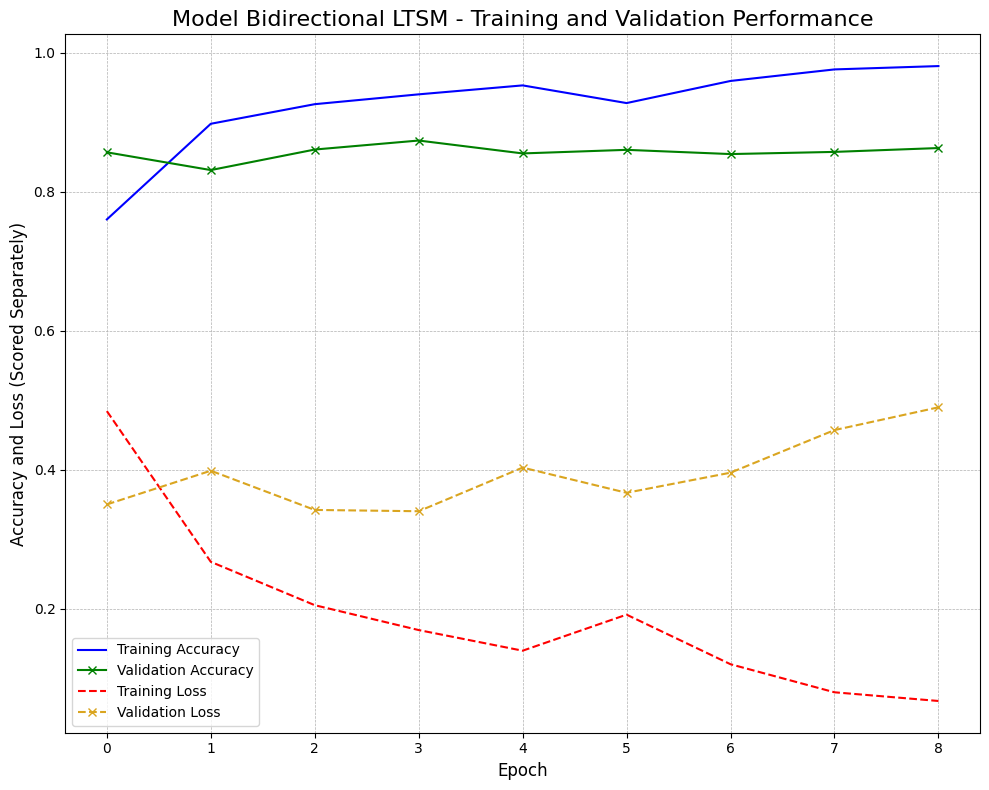


Evaluating model: Bidirectional_LTSM
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.8754 - loss: 0.3384

Model: Bidirectional_LTSM
 Test loss: 0.3402983248233795 Test accuracy: 0.8738399744033813 Time: 488.1
CPU times: user 10min 25s, sys: 2min 11s, total: 12min 37s
Wall time: 8min 31s


In [29]:
%%time

process_model('Bidirectional_LTSM')

## Deep RNN Model


Training model: Deep_RNN
Epoch 1/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - accuracy: 0.5677 - loss: 0.6600 - val_accuracy: 0.8320 - val_loss: 0.4181 - learning_rate: 0.0010
Epoch 2/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 140ms/step - accuracy: 0.8545 - loss: 0.3515 - val_accuracy: 0.8469 - val_loss: 0.3597 - learning_rate: 0.0010
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 140ms/step - accuracy: 0.9049 - loss: 0.2504 - val_accuracy: 0.8674 - val_loss: 0.3341 - learning_rate: 0.0010
Epoch 4/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 140ms/step - accuracy: 0.9298 - loss: 0.1935 - val_accuracy: 0.8616 - val_loss: 0.3425 - learning_rate: 0.0010
Epoch 5/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 140ms/step - accuracy: 0.9506 - loss: 0.1398 - val_accuracy: 0.8459 - val_loss: 0.5168 - learning_rate: 0.0010
Epoch 6/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 140ms/step - accuracy: 0.9687 - loss: 0.0889 - val_accuracy: 0.8508 - val_loss: 0.5190 - learning_rate: 0.0010
Epoch 7/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 

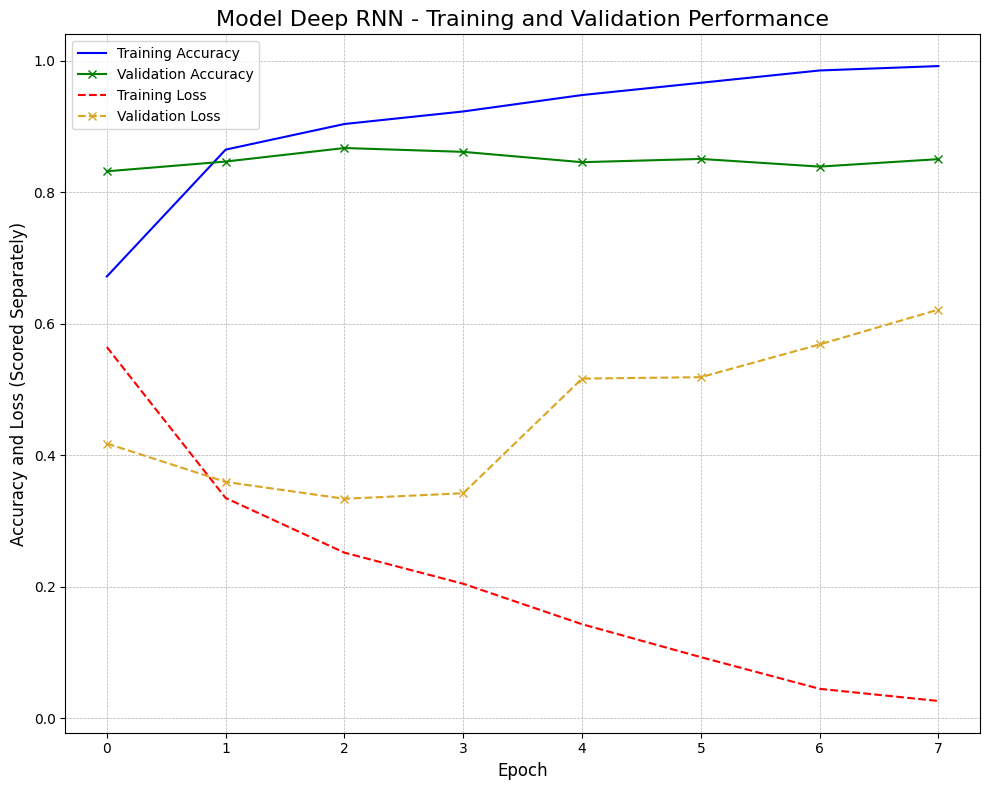


Evaluating model: Deep_RNN
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8666 - loss: 0.3390

Model: Deep_RNN
 Test loss: 0.33406567573547363 Test accuracy: 0.8674399852752686 Time: 220.9
CPU times: user 4min 24s, sys: 36.8 s, total: 5min 1s
Wall time: 3min 52s


In [46]:
%%time

process_model('Deep_RNN')

## Deep LTSM Model


Training model: Deep_LTSM
Epoch 1/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 77s 385ms/step - accuracy: 0.6414 - loss: 0.5872 - val_accuracy: 0.8694 - val_loss: 0.3215 - learning_rate: 0.0010
Epoch 2/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 73s 372ms/step - accuracy: 0.8940 - loss: 0.2787 - val_accuracy: 0.8778 - val_loss: 0.3138 - learning_rate: 0.0010
Epoch 3/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 76s 390ms/step - accuracy: 0.9247 - loss: 0.2039 - val_accuracy: 0.8809 - val_loss: 0.2969 - learning_rate: 0.0010
Epoch 4/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 74s 377ms/step - accuracy: 0.9379 - loss: 0.1705 - val_accuracy: 0.8676 - val_loss: 0.3769 - learning_rate: 0.0010
Epoch 5/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 73s 375ms/step - accuracy: 0.9425 - loss: 0.1562 - val_accuracy: 0.8683 - val_loss: 0.3505 - learning_rate: 0.0010
Epoch 6/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 72s 366ms/step - accuracy: 0.9557 - loss: 0.1279 - val_accuracy: 0.8707 - val_loss: 0.3710 - learning_rate: 0.0010
Epoch 7/25
196/196 ━━━━━━━━━━━━━━━━━━━━ 72s

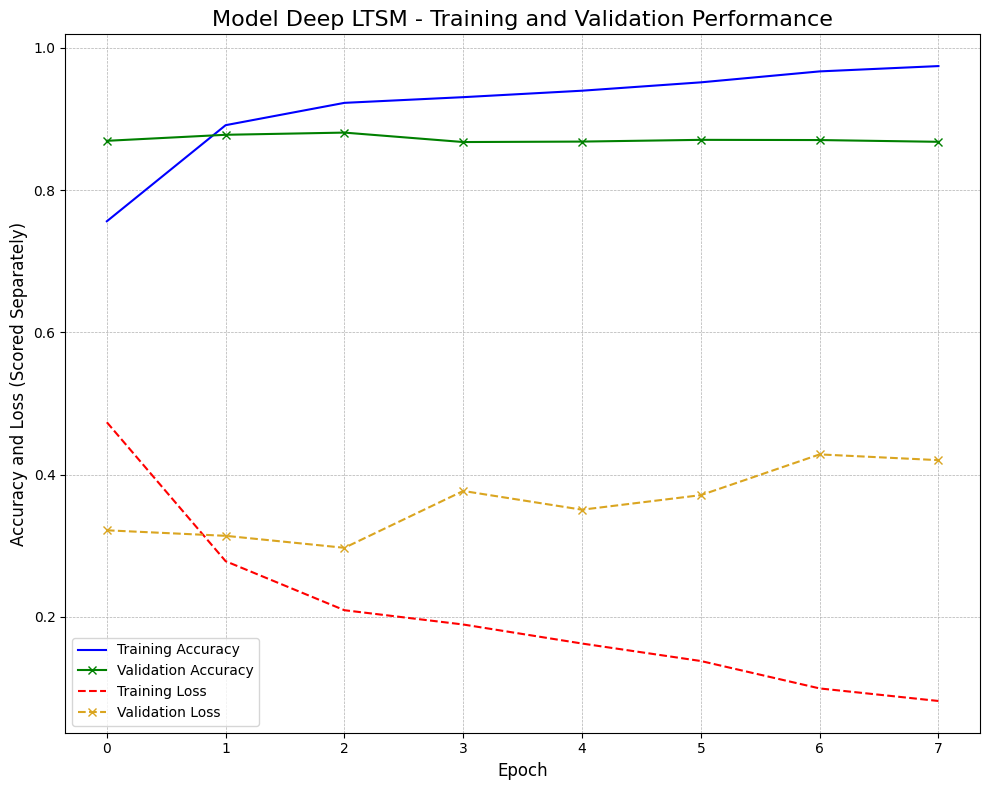


Evaluating model: Deep_LTSM
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.8811 - loss: 0.2963

Model: Deep_LTSM
 Test loss: 0.2969260811805725 Test accuracy: 0.8809199929237366 Time: 589.2
CPU times: user 9min 25s, sys: 1min 49s, total: 11min 15s
Wall time: 10min 12s


In [80]:
%%time

process_model('Deep_LTSM')

## Evaluation summary

In [5]:
get_metrics(file_name=metrics_file_name)

,Loss,Accuracy,Time,Comment
0,0.390961,0.84264,107.5,RNN
1,0.310568,0.86964,281.8,LSTM
2,0.376958,0.84064,177.9,Bidirectional RNN
3,0.340298,0.87384,488.1,Bidirectional LTSM
4,0.334066,0.86744,220.9,Deep RNN
5,0.296926,0.88092,589.2,Deep LTSM


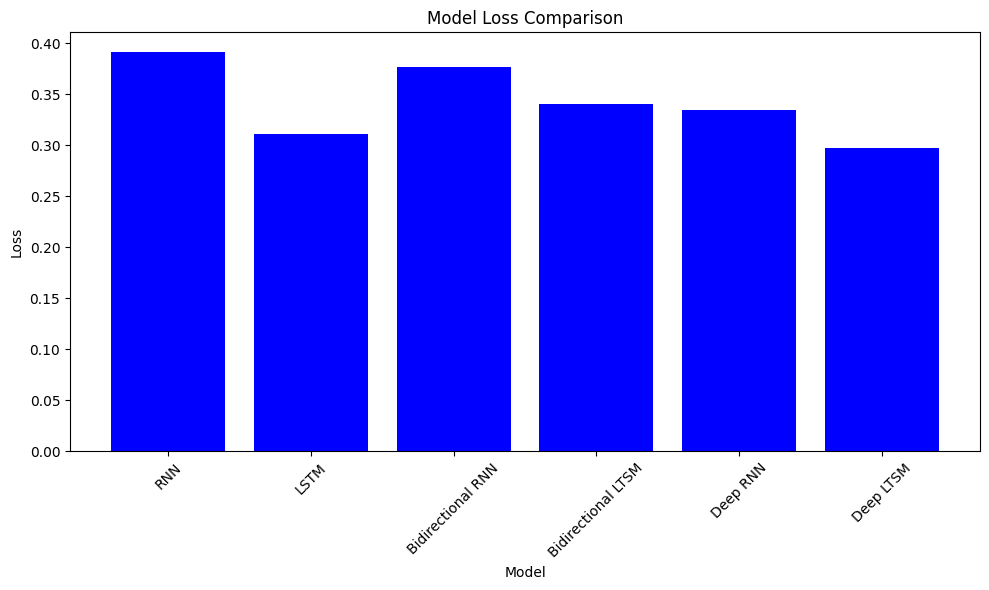

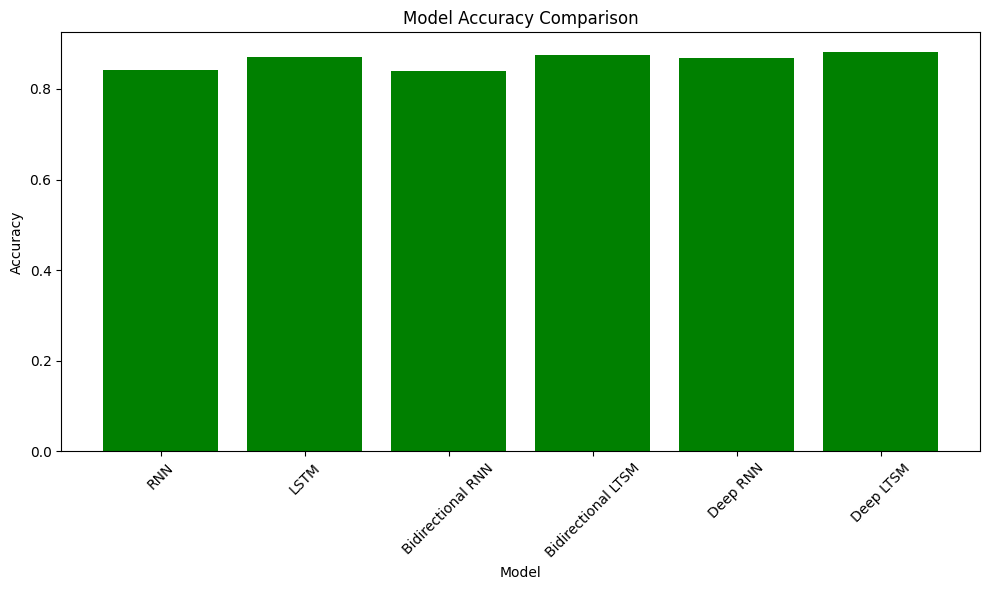

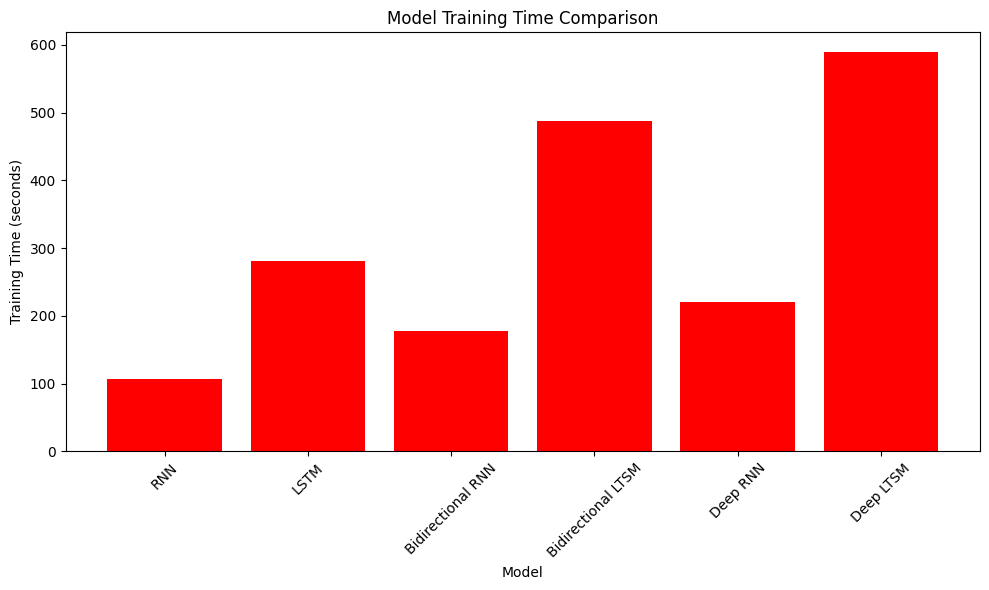

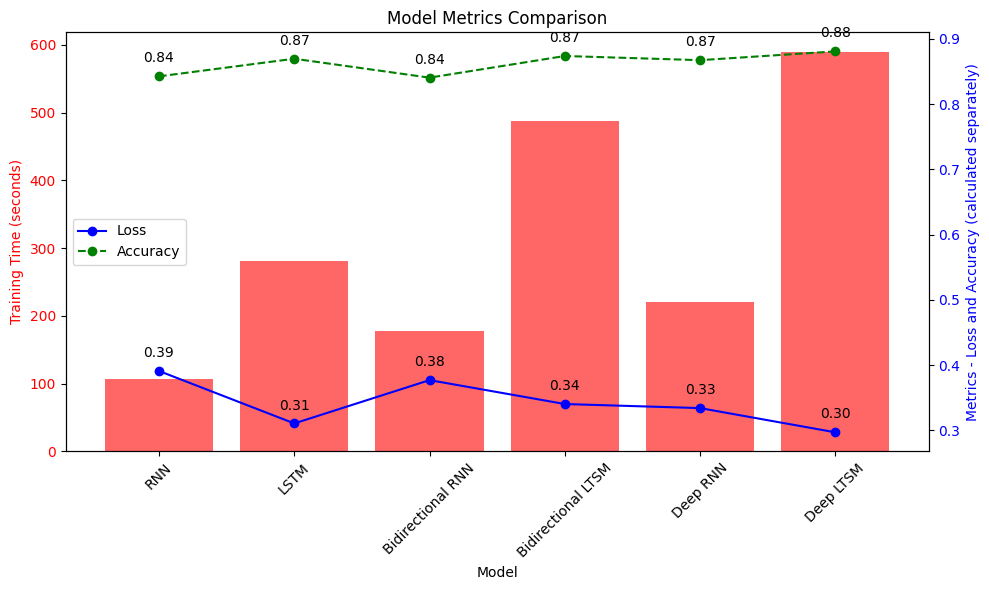

In [8]:
# Load the JSON data
with open('models_metrics.json', 'r') as file:
    data = json.load(file)

# Convert the JSON data to a DataFrame
df = pd.DataFrame(data)
df.replace('_', ' ', regex=True, inplace=True)

# Plot Loss comparison
plt.figure(figsize=(10, 6))
plt.bar(df['Comment'], df['Loss'], color='b')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(df['Comment'], df['Accuracy'], color='g')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Training Time comparison
plt.figure(figsize=(10, 6))
plt.bar(df['Comment'], df['Time'], color='r')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')
plt.title('Model Training Time Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Combined plot with lines for Loss and Accuracy, and bars for Training Time
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=45)

# Bar plot for Training Time
bars = ax1.bar(df['Comment'], df['Time'], color='r', alpha=0.6, label='Training Time (seconds)')
ax1.set_xlabel('Model')
ax1.set_ylabel('Training Time (seconds)', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Create another y-axis for Loss and Accuracy
ax2 = ax1.twinx()

# Line plot for Loss
line1, = ax2.plot(df['Comment'], df['Loss'], color='b', marker='o', label='Loss')
for i, txt in enumerate(df['Loss']):
    ax2.annotate(f'{txt:.2f}', (df['Comment'][i], df['Loss'][i]), textcoords="offset points", xytext=(0,10), ha='center')

ax2.set_ylabel('Loss', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Line plot for Accuracy
line2, = ax2.plot(df['Comment'], df['Accuracy'], color='g', marker='o', linestyle='--', label='Accuracy')
for i, txt in enumerate(df['Accuracy']):
    ax2.annotate(f'{txt:.2f}', (df['Comment'][i], df['Accuracy'][i]), textcoords="offset points", xytext=(0,10), ha='center')

ax2.set_ylabel('Metrics - Loss and Accuracy (calculated separately)')

# Adding legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax2.legend(lines, labels, loc='center left')

plt.title('Model Metrics Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Summary of RNN Models for IMDB Review Classification

### List of Models created and evaluated

1. **RNN Model**: A basic Recurrent Neural Network for classifying IMDB reviews.
2. **LSTM Model**: A Long Short-Term Memory network designed to overcome the vanishing gradient problem in RNNs.
3. **Bidirectional RNN Model**: An RNN that processes data in both forward and backward directions.
4. **Bidirectional LSTM Model**: Combines Bidirectional and LSTM architectures for improved performance.
5. **Deep RNN Model**: An RNN with multiple layers to capture more complex patterns.
6. **Deep LSTM Model**: A multi-layer LSTM neural network to capture complex patterns in the data.

### Comparison of Models

- **Accuracy**: 
  - Deep LSTM: Highest accuracy
  - Bidirectional LSTM: Slightly lower than Deep LSTM
  - Standard RNN and Bidirectional RNN: Lower accuracies
- **Loss**: 
  - Deep LSTM: Lowest loss
  - LSTM: Better than standard RNN, but not as good as Deep LSTM
- **Training Time**: 
  - Deep LSTM: Longest training time
  - Standard RNN: Shortest training time

### Conclusions

1. **Deep LSTM Model**: Best performance in terms of accuracy and loss but requires the most training time.
2. **Bidirectional LSTM Model**: High performance, showing that bidirectional processing with LSTM units is effective.
3. **Standard RNN and Bidirectional RNN Models**: Lower performance compared to LSTM-based models, highlighting the benefits of LSTM units.
4. **Deep Architectures**: Both Deep RNN and Deep LSTM models outperform non-deep models, indicating that deeper neural networks can capture more complex patterns.

In conclusion, LSTM-based models, especially the Deep LSTM model, are very effective for classifying IMDB reviews. Although they require more training time and resources, their higher performance makes them worth the extra effort.